<a href="https://colab.research.google.com/github/IdaCy/error_interp/blob/main/notebooks/initial_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maths Paraphrases Pipeline

This notebook allows to analyse correctness & attention & activations in maths prompts. In order to run these experiments, you need a list of prompts that have a question portion, a colon, and a maths portion:
<question>: <maths>
e.g.
Please solve: 4 + 93.

Your prompts are the `'normal'` prompts. You can give the list to e.g. to [Grok](https://grok.com/) and ask it to generate paraphrases and build a JSON like the below`

Prepare a JSON like this:

```
[
    {
        "element_index": 1,
        "normal": "Solve this task: 4 + 93 =",
        "nicer": "Please solve this task: 4 + 93 =",
        "urgent": "Solve this task urgently: 4 + 93 =",
        ... (possibly more keys)
    },
    {
        "element_index": 2,
        "normal": "Please find the result: 6 - 4 =",
        "nicer": "Please kindly find the result: 6 - 4 =",
        "urgent": "Please find the result immediately: 6 - 4 =",
        ... (possibly more keys)
    },
    {
        "element_index": 3,
        "normal": "What is the solution for: 9 - 7 =",
        "nicer": "Please what is the solution for: 9 - 7 =",
        "urgent": "What is the solution for, extremely important: 9 - 7 =",
        ... (possibly more keys)
    },
... (more curly brackets)
]
```
Fill it with 100 entries.

Then start by importing the required libraries:

In [1]:
# Check Python version (optional):
import sys
print("Python version:", sys.version)

# Get installations
!pip install --quiet torch numpy matplotlib scikit-learn pandas
!pip install --quiet huggingface_hub transformers

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# If you want to check GPU usage:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.7 MB/s eta 0:00:00
Using device: cuda


In order to save the results more permanently than just in this session, we use Google Drive. Run the following to connect your drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# After running this cell, follow the link to grant Colab access to your Google Drive.

Mounted at /content/drive


Now, connect the github repository by running the below script.

This repository has one folder for each experiment. It is structured like this:

```
ParaphrX/
├── 0_data/
│   ├── maths.json         <- put your JSON here
│   └── instructions.json
├── 1_utils/
│   ├── hpc/
│   └── run_scripts/       <- always useful scripts
│       ├── load_json.py
│       ├── load_model.py
│       ├── logger.py
│       └── read_predictions.py
├── 2_inference/
│   ├── hpc/
│   └── run_scripts/
│       └── attn_act_logi.py
├── 3_maths_eval/         <- evaluating predictions with mats
│   ├── hpc/
│   └── run_scripts/
│       ├── parse_predictions.py
│       └── evaluate_predictions.py
├── 4_semantics_eval/
│   ├── hpc/
│   └── run_scripts/
├── 5_attention_fractions/
│   ├── hpc/
│   └── run_scripts/
│       └── dirs_eval.py
├── requirements.txt
└── README.md
```

Ignore the `'hpc'`folders for now; it is for running the scripts through the Imperial SLURM.

In [4]:
!git clone https://github.com/IdaCy/ParaphrX.git
%cd ParaphrX

Cloning into 'ParaphrX'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 122 (delta 38), reused 102 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (122/122), 106.82 KiB | 13.35 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/ParaphrX


Now, connect a huggingface account.

If you don't have one yet, set it up - it's really straightforward - and then just click at your profile image, and select in the dropdown to create a `token`. You'll be prompted to insert that token when running the below cell.

In [5]:
!pip install huggingface_hub --quiet

from huggingface_hub import notebook_login

# This will prompt you in Colab to enter your HF token or log in directly
notebook_login()

# Logging Setup

By running the below script, you set up a logger to run during inference. If you don't change the logging level, it will print all the progress stuff to the log file - `progress.log` in the logs/ directory - and only warnings would be printed below the cell.

In [6]:
import logging
from b_utils.run_scripts.logger import init_logger
logging.basicConfig(level=logging.INFO)

logger = init_logger(
    log_file="logs/progress.log",
    console_level=logging.WARNING,  # only warnings to console
    file_level=logging.DEBUG        # full debug info in the file
)

## Inference with Extractions

---
**!Efficiency Information!** You might want to only run this chapter - getting the model & running inference on each prompt type - with a higher-power GPU (e.g. A100). They are saved into your drive. You can then switch to lower GPU or even CPU for any following analysis.
---
---

The below script runs inference with a specific key from your JSON. For example, you may want to start by only running the `normal` prompts through your model.

You have this JSON in your `a_data/`:
```
[
    {
        "element_index": 1,
        "normal": "Solve this task: 4 + 93 =",        <- running this
        "nicer": "Please solve this task: 4 + 93 =",
        ... (possibly more keys)
    },
    {
        "element_index": 2,
        "normal": "Please find the result: 6 - 4 =",  <- running this
        "nicer": "Please kindly find the result: 6 - 4 =",
        ... (possibly more keys)
    },
... (more curly brackets)
]
```

And you would repeatedly run the inference on one 'normal' prompt, capture hidden values, next prompt, capture hidden values...

The results are saved in `c_inference/extractions/`.

Get the functions from the scripts:

In [7]:
from b_utils.run_scripts.load_model import load_model
from b_utils.run_scripts.load_json import load_json_prompts
from c_inference.run_scripts.attn_act_logi import run_inf

With the below script, we download the model weights _once_, they are then stored in 'model' and you won't have to do this relatively higher-compute execution again after. It is used in all your inference runs.

Don't forget exchanging the `None` with your own Huggingface Token (hf_token)!

In [8]:
model, tokenizer = load_model(
    model_name="google/gemma-2-9b-it",
    use_bfloat16=True,
    hf_token="",
    logger=logger
)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:862: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

### Running Inference

You can now run inference on your scripts. It extracts:
- every 5th layer attention
- every 5th layer activations
- final logits
- predictions


In [9]:
# Setup for all inference runs
jfile = "a_data/maths.json"
out_dir = "/content/drive/MyDrive/ParaphrX/c_inference/extractions/"
batch_size = 128

# Make the directory in drive to save results
!mkdir out_dir

In [10]:
# prompt version / JSON key used
prompt = "normal"

data = load_json_prompts(file_path=jfile, prompt_key=prompt, logger=logger)
run_inf(model, tokenizer, data, output_dir=out_dir+prompt, batch_size=batch_size, logger=logger)

[WARNING] === Starting inference. #samples=1000, batch_size=128 ===
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
[WARNING] === Inference Complete ===


In [11]:
# prompt version / JSON key used
prompt = "nicer"

data = load_json_prompts(file_path=jfile, prompt_key=prompt, logger=logger)
run_inf(model, tokenizer, data, output_dir=out_dir+prompt, batch_size=batch_size, logger=logger)

[WARNING] === Starting inference. #samples=1000, batch_size=128 ===
[WARNING] === Inference Complete ===


In [12]:
# prompt version / JSON key used
prompt = "urgent"

data = load_json_prompts(file_path=jfile, prompt_key=prompt, logger=logger)
run_inf(model, tokenizer, data, output_dir=out_dir+prompt, batch_size=batch_size, logger=logger)

[WARNING] === Starting inference. #samples=1000, batch_size=128 ===
[WARNING] === Inference Complete ===


In [13]:
# any other prompt version / JSON key? - change here
prompt = "insulting"

data = load_json_prompts(file_path=jfile, prompt_key=prompt, logger=logger)
run_inf(model, tokenizer, data, output_dir=out_dir+prompt, batch_size=batch_size, logger=logger)

[WARNING] === Starting inference. #samples=1000, batch_size=128 ===
[WARNING] === Inference Complete ===


## Check Your Predictions

You don't need GPU for this. You can switch to CPU.



In [14]:
from b_utils.run_scripts.read_predictions import read_predictions

In [15]:
import logging
from b_utils.run_scripts.logger import init_logger
logging.basicConfig(level=logging.INFO)

# prompt version you want to read predictions of:
prompt = "normal"

predictions = read_predictions(
    read_output_dir="c_inference/extractions/" + prompt,
    max_predictions=20,
    write_predictions_file="logs/predictions.txt",
    log_file="logs/read_predictions.log"
)
print(f"Collected {len(predictions)} predictions.")

[INFO] === Starting read_predictions function ===
INFO:ReadPredictionsLogger:=== Starting read_predictions function ===
[INFO] read_output_dir = c_inference/extractions/normal
INFO:ReadPredictionsLogger:read_output_dir = c_inference/extractions/normal
[INFO] log_file = logs/read_predictions.log
INFO:ReadPredictionsLogger:log_file = logs/read_predictions.log
[INFO] max_predictions = 20
INFO:ReadPredictionsLogger:max_predictions = 20
[INFO] write_predictions_file = logs/predictions.txt
INFO:ReadPredictionsLogger:write_predictions_file = logs/predictions.txt
[WARNING] No .pt files found in c_inference/extractions/normal. Returning empty list.


Collected 0 predictions.


## Evaluate Your Predictions

How many tasks did the LLM solve correctly?

Run the below on each prompt type, and find the percentage.

In [16]:
from d_maths_eval.run_scripts.parse_predictions import parse_prediction_text
from d_maths_eval.run_scripts.evaluate_predictions import evaluate_predictions
allowed_operations = "+-*÷"
pt_path = "/content/drive/MyDrive/ParaphrX/c_inference/extractions"
log_path = "logs/extraction_log_"
results_path = "/content/drive/MyDrive/ParaphrX/d_maths_eval/output"
!mkdir -p results_path

In [17]:
pr_type = "normal"
overall_accuracy = evaluate_predictions(pt_file=pt_path + pr_type,
                                        log_file=log_path + pr_type + ".txt",
                                        allowed_operations=allowed_operations,
                                        results_file=results_path + pr_type + ".txt")

print(f"Overall Correctness: {overall_accuracy:.2f}%")

Overall Correctness: 0.00%


In [18]:
pr_type = "nicer"
overall_accuracy = evaluate_predictions(pt_file=pt_path + pr_type,
                                        log_file=log_path + pr_type + ".txt",
                                        allowed_operations=allowed_operations,
                                        results_file=results_path + pr_type + ".txt")

print(f"Overall Correctness: {overall_accuracy:.2f}%")

Overall Correctness: 0.00%


In [19]:
pr_type = "urgent"
overall_accuracy = evaluate_predictions(pt_file=pt_path + pr_type,
                                        log_file=log_path + pr_type + ".txt",
                                        allowed_operations=allowed_operations,
                                        results_file=results_path + pr_type + ".txt")

print(f"Overall Correctness: {overall_accuracy:.2f}%")

Overall Correctness: 0.00%


In [20]:
pr_type = "insulting"
overall_accuracy = evaluate_predictions(pt_file=pt_path + pr_type,
                                        log_file=log_path + pr_type + ".txt",
                                        allowed_operations=allowed_operations,
                                        results_file=results_path + pr_type + ".txt")

print(f"Overall Correctness: {overall_accuracy:.2f}%")

Overall Correctness: 0.00%


## Attention Analysis

This part analyses how much attention was on the different parts of the prompts.

All the result files (PT files) are stored in dedicated directories - which are all part of one overall directory. You pass along the path to the overall directory, and it will compare all your prompt outputs.

Found 8 .pt files in: /content/drive/MyDrive/ParaphrX/c_inference/extractions/normal (prompt_type='normal')
Found 8 .pt files in: /content/drive/MyDrive/ParaphrX/c_inference/extractions/nicer (prompt_type='nicer')
Found 8 .pt files in: /content/drive/MyDrive/ParaphrX/c_inference/extractions/urgent (prompt_type='urgent')
Found 8 .pt files in: /content/drive/MyDrive/ParaphrX/c_inference/extractions/insulting (prompt_type='insulting')
=== Average fraction of attention on prompt vs. task portion ===
             frac_prompt  frac_task
prompt_type                        
insulting       0.836400   0.163600
nicer           0.831658   0.168342
normal          0.813858   0.186142
urgent          0.850337   0.149663
Saved fraction summary CSV to: /content/drive/MyDrive/ParaphrX/f_attention_fractions/output/normal_nicer_urgent_insulting/prompt_task_fraction_aggregate.csv


<Figure size 640x480 with 0 Axes>

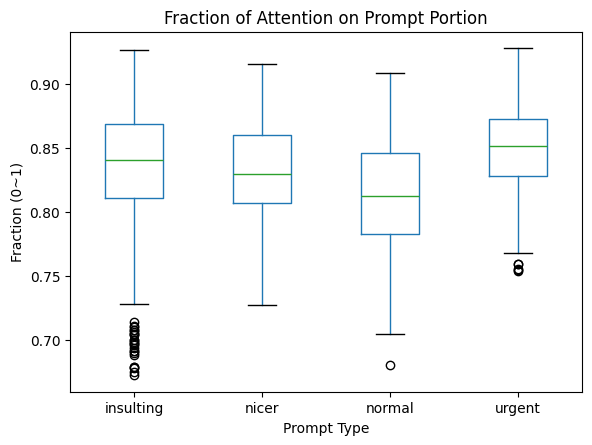

<Figure size 640x480 with 0 Axes>

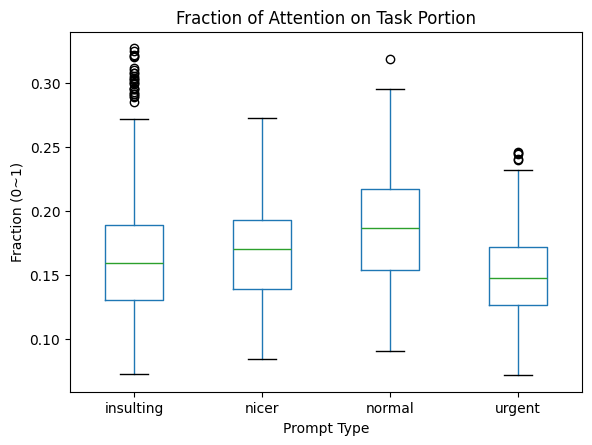

=== Per-layer average fraction of attention on prompt vs. task ===
                   frac_prompt  frac_task
prompt_type layer                        
insulting   0         0.675270   0.324730
            5         0.675276   0.324724
            10        0.675274   0.324726
            15        0.675272   0.324728
nicer       0         0.661640   0.338360
            5         0.661645   0.338355
            10        0.661644   0.338356
            15        0.661642   0.338358
normal      0         0.635737   0.364263
            5         0.635743   0.364257
            10        0.635743   0.364257
            15        0.635739   0.364261
urgent      0         0.702773   0.297227
            5         0.702778   0.297222
            10        0.702776   0.297224
            15        0.702775   0.297225
Saved per-layer fraction CSV to: /content/drive/MyDrive/ParaphrX/f_attention_fractions/output/normal_nicer_urgent_insulting/prompt_task_fraction_perlayer.csv


<Figure size 640x480 with 0 Axes>

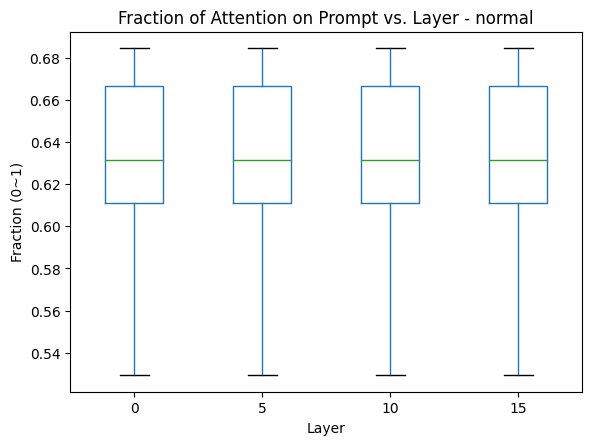

<Figure size 640x480 with 0 Axes>

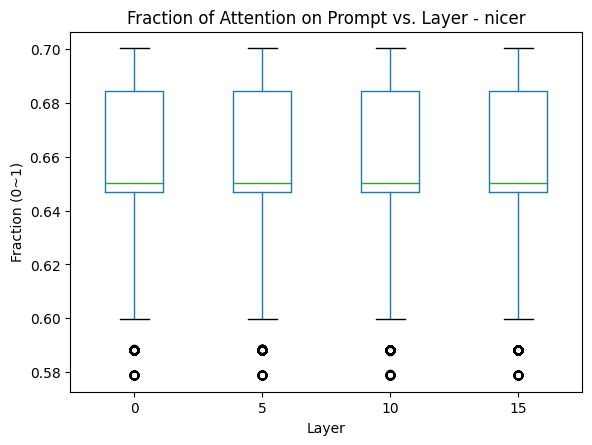

<Figure size 640x480 with 0 Axes>

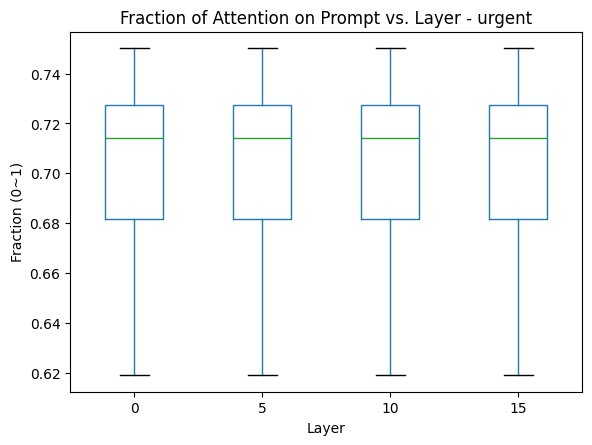

<Figure size 640x480 with 0 Axes>

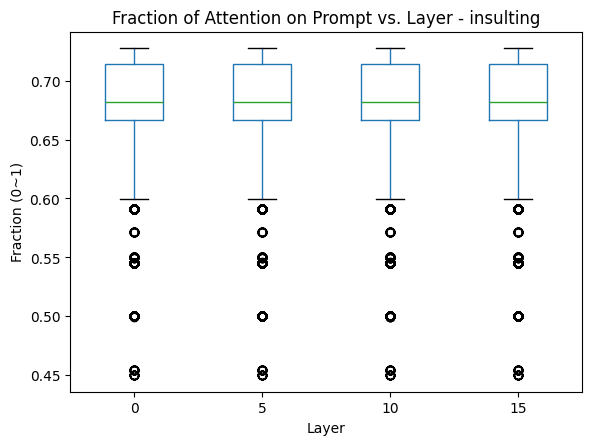

All plots and CSVs saved to: /content/drive/MyDrive/ParaphrX/f_attention_fractions/output/normal_nicer_urgent_insulting
Done!


In [21]:
from f_attention_fractions.run_scripts.dirs_eval import run_attention_extraction
!mkdir -p "/content/drive/MyDrive/ParaphrX/f_attention_fractions/output"

run_attention_extraction(
    tokenizer=tokenizer,
    extraction_base_dir="/content/drive/MyDrive/ParaphrX/c_inference/extractions",
    prompt_types="normal nicer urgent insulting",
    output_dir="/content/drive/MyDrive/ParaphrX/f_attention_fractions/output"
)

In [32]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 1), reused 4 (delta 1), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 351 bytes | 351.00 KiB/s, done.
From https://github.com/IdaCy/ParaphrX
   ea9171e..0efa3c3  main       -> origin/main
Updating ea9171e..0efa3c3
Fast-forward
 g_linear_class/run_scripts/{train_classifier.py => train_classifier2.py} | 0
 1 file changed, 0 insertions(+), 0 deletions(-)
 rename g_linear_class/run_scripts/{train_classifier.py => train_classifier2.py} (100%)


In [33]:
from g_linear_class.run_scripts.train_classifier2 import load_features_from_dir, train_and_evaluate

In [43]:
dir1 = "/content/drive/MyDrive/ParaphrX/c_inference/extractions/normal"
dir2 = "/content/drive/MyDrive/ParaphrX/c_inference/extractions/nicer"

In [45]:
layer = 0

# Load features from each condition
features1 = load_features_from_dir(dir1, layer)
features2 = load_features_from_dir(dir2, layer)

# Create labels: 0 for normal and 1 for nicer
labels1 = np.zeros(features1.shape[0], dtype=int)
labels2 = np.ones(features2.shape[0], dtype=int)

X = np.concatenate([features1, features2], axis=0)
y = np.concatenate([labels1, labels2], axis=0)

mean_acc = train_and_evaluate(X, y, cv=5)
print(f"Layer {layer}: Mean cross-validation accuracy = {mean_acc*100:.2f}%")

Layer 0: Mean cross-validation accuracy = 91.75%


In [46]:
layer = 5

# Load features from each condition
features1 = load_features_from_dir(dir1, layer)
features2 = load_features_from_dir(dir2, layer)

# Create labels: 0 for normal and 1 for nicer
labels1 = np.zeros(features1.shape[0], dtype=int)
labels2 = np.ones(features2.shape[0], dtype=int)

X = np.concatenate([features1, features2], axis=0)
y = np.concatenate([labels1, labels2], axis=0)

mean_acc = train_and_evaluate(X, y, cv=5)
print(f"Layer {layer}: Mean cross-validation accuracy = {mean_acc*100:.2f}%")

Layer 5: Mean cross-validation accuracy = 92.00%


In [47]:
layer = 10

# Load features from each condition
features1 = load_features_from_dir(dir1, layer)
features2 = load_features_from_dir(dir2, layer)

# Create labels: 0 for normal and 1 for nicer
labels1 = np.zeros(features1.shape[0], dtype=int)
labels2 = np.ones(features2.shape[0], dtype=int)

X = np.concatenate([features1, features2], axis=0)
y = np.concatenate([labels1, labels2], axis=0)

mean_acc = train_and_evaluate(X, y, cv=5)
print(f"Layer {layer}: Mean cross-validation accuracy = {mean_acc*100:.2f}%")

Layer 10: Mean cross-validation accuracy = 92.00%


In [48]:
layer = 15

# Load features from each condition
features1 = load_features_from_dir(dir1, layer)
features2 = load_features_from_dir(dir2, layer)

# Create labels: 0 for normal and 1 for nicer
labels1 = np.zeros(features1.shape[0], dtype=int)
labels2 = np.ones(features2.shape[0], dtype=int)

X = np.concatenate([features1, features2], axis=0)
y = np.concatenate([labels1, labels2], axis=0)

mean_acc = train_and_evaluate(X, y, cv=5)
print(f"Layer {layer}: Mean cross-validation accuracy = {mean_acc*100:.2f}%")

Layer 15: Mean cross-validation accuracy = 92.15%


In [50]:
dir1 = "/content/drive/MyDrive/ParaphrX/c_inference/extractions/normal"
dir2 = "/content/drive/MyDrive/ParaphrX/c_inference/extractions/urgent"

In [51]:
layer = 0

# Load features from each condition
features1 = load_features_from_dir(dir1, layer)
features2 = load_features_from_dir(dir2, layer)

# Create labels: 0 for normal and 1 for nicer
labels1 = np.zeros(features1.shape[0], dtype=int)
labels2 = np.ones(features2.shape[0], dtype=int)

X = np.concatenate([features1, features2], axis=0)
y = np.concatenate([labels1, labels2], axis=0)

mean_acc = train_and_evaluate(X, y, cv=5)
print(f"Layer {layer}: Mean cross-validation accuracy = {mean_acc*100:.2f}%")

Layer 0: Mean cross-validation accuracy = 100.00%


In [52]:
layer = 5

# Load features from each condition
features1 = load_features_from_dir(dir1, layer)
features2 = load_features_from_dir(dir2, layer)

# Create labels: 0 for normal and 1 for nicer
labels1 = np.zeros(features1.shape[0], dtype=int)
labels2 = np.ones(features2.shape[0], dtype=int)

X = np.concatenate([features1, features2], axis=0)
y = np.concatenate([labels1, labels2], axis=0)

mean_acc = train_and_evaluate(X, y, cv=5)
print(f"Layer {layer}: Mean cross-validation accuracy = {mean_acc*100:.2f}%")

Layer 5: Mean cross-validation accuracy = 100.00%


In [53]:
dir1 = "/content/drive/MyDrive/ParaphrX/c_inference/extractions/normal"
dir2 = "/content/drive/MyDrive/ParaphrX/c_inference/extractions/insulting"

In [55]:
layer = 10

# Load features from each condition
features1 = load_features_from_dir(dir1, layer)
features2 = load_features_from_dir(dir2, layer)

# Create labels: 0 for normal and 1 for nicer
labels1 = np.zeros(features1.shape[0], dtype=int)
labels2 = np.ones(features2.shape[0], dtype=int)

X = np.concatenate([features1, features2], axis=0)
y = np.concatenate([labels1, labels2], axis=0)

mean_acc = train_and_evaluate(X, y, cv=5)
print(f"Layer {layer}: Mean cross-validation accuracy = {mean_acc*100:.2f}%")

Layer 10: Mean cross-validation accuracy = 100.00%
